### Import packages

In [4]:
import numpy as np
import os
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import Dataset
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import minimize


### Import Data

In [2]:
class DiabetesDataset(Dataset):
    def __init__(self, patient_file,transform=None,target_transform=None):
        self.data=pd.read_csv(patient_file)
        self.diabete_record=self.data.iloc[:,1]
        self.date=self.data.iloc[:,0]
        self.insulin_doses=self.data.iloc[:,3]
        self.meal=self.data.iloc[:,2]
        self.nonin_medi=self.data.iloc[:,4]
        self.transform=transform
        self.target_transform=target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):       
        diabete=self.diabete_record.iloc[idx]
        label=self.labels[idx]
        insulin_doses=self.insulin_doses.iloc[idx]
        if self.transform:
            diabete=self.transform(diabete)
        if self.target_transform:
            label=self.target_transform(label)
        return torch.tensor(diabete),insulin_doses
    

### Data Preperation

In [ ]:
patient1=DiabetesDataset('/home/fyyy0407/RL/Deep_Q_Learning/T2DM/1.csv')
df=pd.read_csv('/home/fyyy0407/RL/Deep_Q_Learning/T2DM/1.csv')

indices = df.index[patient1.meal== 1].tolist()
meal_times=len(indices)
total_y=[]
total_v=[]
total_init=[]
total_len=[]
for i in range(0,meal_times-1):
    index=indices[i]
    next_index=indices[i+1]
    dv_y=[patient1.diabete_record[index:next_index+1].values,\
          patient1.insulin_doses[index:next_index+1].values+10*patient1.nonin_medi[index:next_index+1].values]
    dv_y_init = [sublist[2] for sublist in dv_y]
    dv_v=patient1.insulin_doses[index:next_index+1]+10*patient1.nonin_medi[index:next_index+1]
    dv_len=next_index-index
    total_y.append(dv_y)
    total_v.append(dv_v)
    total_init.append(dv_y_init)
    total_len.append(dv_len)
print(np.array((total_y[0])).shape)  
print(total_len[0]) 


### Define Glucose-Insulin System

In [3]:
params={
    "Ib":24.04,
    "G*":9,
    "tg":6.5,
    "Vg":0.18,
    "Vi":0.25,
    "gamma":15.92,
    "Tgh":0.0023,
    "Tigmax":1.685,
    "Kxi":0.038,
    "Kxgi":3.15e-5,
    "dt":1
}
theta=np.array(list(params.values()))

def glucose_insulin_system(t,Y,V,theta,buffer):
    G_t,I_t=Y[0],Y[1]
    
    if int(t)>=len(V):
        V_t=V[-1]
    else:
        V_t=V[int(t)]
    G_delayed = buffer.get_delayed_glucose()
    
    dG_dt=-theta[10]*G_t*I_t+theta[7]/theta[4]

    def phi(G_delayed):
        return (G_delayed / theta[2])**theta[6] / (1 + (G_delayed / theta[2])**theta[6])
    
    dI_dt= -theta[9]*I_t+(theta[8]/theta[5])*phi(G_delayed)+(V_t/theta[5]) 
    return dG_dt,dI_dt

class GlucoseBuffer:
    def __init__(self, tau_g, initial_glucose, dt):
        self.buffer = np.full(int(tau_g / dt), initial_glucose)
        self.tau_g = tau_g
        self.dt = dt #time step between successive glucose values
        self.pos = 0  # current position in the buffer
    
    def update(self, glucose):
        self.buffer[self.pos] = glucose
        self.pos = (self.pos + 1) % len(self.buffer)
    
    def get_delayed_glucose(self):
        return self.buffer[self.pos]
    
def solve_system(t_span,theta, Y0,V):
    dt=params['dt']
    buffer= GlucoseBuffer(params['tg'], initial_glucose=Y0[0],dt=dt)
    t_eval = np.arange(t_span[0], t_span[1], buffer.dt)
    sol = solve_ivp(glucose_insulin_system, t_span, Y0,args=(V,theta,buffer), t_eval=t_eval, method='RK45')
    return sol
# add Gb from the measured data
# theta = np.insert(theta, 1, Y1_piece_init[0]) 
# predict_g=[]
# for i in range(0,meal_times-1):
#     t_span=[0,total_len[i]]
#     Vi=total_v[i].values
#     INITi=total_init[i]
#     theta_i = np.insert(theta, 1, INITi[0]) 
#     sol=solve_system(t_span,theta_i,INITi,Vi)
#     predict_g.extend(sol.y[0].tolist())

# print(predict_g)

### Define cost function

In [4]:
def Qls(Y,sigma,theta,total_v,total_len,total_init,meal_times):
    # Ne, Ny, Nt = observed_data.shape
    # model_predictions=solve_system(t_span,theta,Y0,V1)
    # predict_g=model_predictions.y[0]
    measure_g=Y
    predict_g=[]
    for i in range(0,meal_times-1):
        t_span=[0,total_len[i]]
        Vi=total_v[i].values
        INITi=total_init[i]

        theta_i = np.insert(theta, 1, INITi[0]) 
        sol=solve_system(t_span,theta_i,INITi,Vi)
        predict_g.extend(sol.y[0].tolist())

    ############################## last version #################################
    # Residual= (predict_g - measure_g) / sigma
    # predict_g_tensor = torch.tensor(predict_g, dtype=torch.float32)
    # measure_g_tensor = torch.tensor(measure_g, dtype=torch.float32)
    # criterion = torch.nn.MSELoss()
    # Loss = criterion(predict_g_tensor, measure_g_tensor)
    # likelihood=Residual@(Residual.T)
    # return likelihood,Loss.item()

    ############################## new version ###################################
    predict_g_tensor = torch.tensor(predict_g, dtype=torch.float32)
    measure_g_tensor = torch.tensor(measure_g, dtype=torch.float32)
    criterion = torch.nn.MSELoss()
    Loss=[criterion(pg,mg).item() for pg,mg in zip(predict_g_tensor,measure_g_tensor)]
    Residual=[ls/sigma for ls in Loss]
    Residual=np.array(Residual)
    likelihood=Residual@(Residual.T) 
    
    # # Plot measured glucose
    # plt.plot(measure_g, label='Measured Glucose', color='blue')
    # plt.plot(predict_g, label='Predicted Glucose', color='red')
    # plt.plot(25*patient1.meal,label='Meal Plan',color='green')
    # plt.title('Glucose Measurement vs. Prediction')
    # plt.xlabel('Time or Sample Index')
    # plt.ylabel('Glucose Level')
    # plt.legend()
    # plt.show()  
    return likelihood


   

# sigma=5
# # theta=np.array(params.values())
# index=indices[0]
# last_index=indices[-1]
# G=patient1.diabete_record.values[index:last_index]
# llh=Qls(G,sigma,theta)
# print(llh)

In [34]:
directory = '/home/fyyy0407/RL/Deep_Q_Learning/T2DM'  # Replace with the correct path to your 'T2DM' folder.
theta_bounds=[(20,60),(8,10),(0,7),(0.1,0.2),(0.2,0.3),(2,16),(0.002,0.003),(0.5,2),(0,0.2),(3e-5,1e-4),(1,1)]
# Loop through the files in the directory.
theta_history=[]
loss=[]
alpha=0.5
sigma=5

# def Qr(theta,sigma,alpha,G,total_v,total_init,meal_times):
    # qls=Qls(G,sigma,theta,total_v,total_init,meal_times)
    # regulation=np.sum(np.array(theta)**2)
    # return qls+alpha*regulation
def Qr(theta,sigma,alpha,round):
    qls_sum=0
    file_loop_counter=0
    for filename in os.listdir(directory):
        # theta_history.append(theta)
        if file_loop_counter==round:
            break
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        patient1=DiabetesDataset(file_path)
        indices = df.index[patient1.meal== 1].tolist()
        meal_times=len(indices)
        total_y=[]
        total_v=[]
        total_init=[]
        total_len=[]
        for i in range(0,meal_times-1):
            index=indices[i]
            next_index=indices[i+1]
            dv_y=[patient1.diabete_record[index:next_index+1].values,\
            patient1.insulin_doses[index:next_index+1].values+20*patient1.nonin_medi[index:next_index+1].values]

            dv_y_init = [sublist[0] for sublist in dv_y]
            dv_v=patient1.insulin_doses[index:next_index+1]+20*patient1.nonin_medi[index:next_index+1]
            dv_len=next_index-index
            total_y.append(dv_y)
            total_v.append(dv_v)
            total_init.append(dv_y_init)
            # print(total_init[0])
            total_len.append(dv_len)
        index=indices[0]
        last_index=indices[-1]
        G=patient1.diabete_record.values[index:last_index]
        file_loop_counter+=1
        # print(file_loop_counter)
        qls=Qls(G,sigma,theta,total_v,total_len,total_init,meal_times)
        qls_sum+=qls
    regulation=np.sum(np.array(theta)**2)
    return qls_sum+alpha*regulation

for round in np.arange(30): 
    result=minimize(Qr,theta,args=(sigma,alpha,round),bounds=theta_bounds)
# result = minimize(Qr, theta, args=(sigma,alpha,G,total_v,total_init,meal_times), bounds=theta_bounds)
    theta = result.x
    theta_history.append(theta)
    print(round)

#################################### last version ###################################
# file_loop_counter=1
# for filename in os.listdir(directory):
#     theta_history.append(theta)
#     if file_loop_counter==3:
#         break
#     # print(1)
#     file_path = os.path.join(directory, filename)
#     df = pd.read_csv(file_path)
#     patient1=DiabetesDataset(file_path)
#     # print(2)
#     indices = df.index[patient1.meal== 1].tolist()
#     meal_times=len(indices)
#     total_y=[]
#     total_v=[]
#     total_init=[]
#     total_len=[]
#     for i in range(0,meal_times-1):
#         index=indices[i]
#         next_index=indices[i+1]
#         dv_y=[patient1.diabete_record[index:next_index+1].values,\
#         #   patient1.insulin_doses[index:next_index+1].values+20*patient1.nonin_medi[index:next_index+1].values]
#             patient1.insulin_doses[index:next_index+1].values]
#         dv_y_init = [sublist[1] for sublist in dv_y]
#         dv_v=patient1.insulin_doses[index:next_index+1]+20*patient1.nonin_medi[index:next_index+1]
        # dv_len=next_index-index
        # total_y.append(dv_y)
        # total_v.append(dv_v)
        # total_init.append(dv_y_init)
        # total_len.append(dv_len)

    # index=indices[0]
    # last_index=indices[-1]
    # G=patient1.diabete_record.values[index:last_index]

    # llh=Qls(G,sigma,theta,total_v,total_init,meal_times,loss)

    # file_loop_counter+=1
    # print(file_loop_counter)
    #define bounds for each parameter
    
#     result = minimize(Qr, theta, args=(sigma,alpha,G,total_v,total_init,meal_times,loss), bounds=theta_bounds)
# # The optimized parameters
#     theta = result.x
    # llh,Last_loss=Qls(G,sigma,theta,total_v,total_init,meal_times,loss)
    # loss.append(Last_loss)

    

# plt.plot(loss,label='loss',color='blue')
# plt.show

    

0
1
2
3
4


KeyboardInterrupt: 

In [ ]:
# loss=[value for value in loss if value<2000]
idx=loss.index(min(loss))
lg=len(loss)
plt.plot(loss,label='loss',color='blue')
plt.show
print(idx)
# 创建一个DataFrame
loss_data = pd.DataFrame({'X': np.arange(lg), 'Y': loss})
# 使用seaborn绘制散点图和趋势线
sns.lmplot(x='X',y= 'Y', data=loss_data, ci=None)
plt.show()

### Regularization

In [ ]:
alpha=0.5

def Qr(theta,sigma,alpha,G):
    qls=Qls(G,sigma,theta)
    regulation=np.sum(np.array(theta)**2)
    return qls+alpha*regulation


### Optimization

In [ ]:
#define bounds for each parameter
theta_bounds=[(20,60),(8,10),(0,7),(0.1,0.2),(0.2,0.3),(2,16),(0.002,0.003),(0.5,2),(0,0.2),(3e-5,1e-4),(1,1)]
result = minimize(Qr, theta, args=(sigma,alpha,G,meal_times), bounds=theta_bounds)

# The optimized parameters
theta = result.x
# print(theta_optimal)

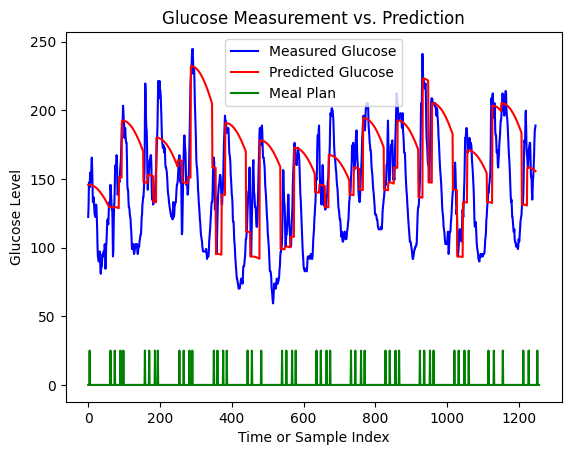

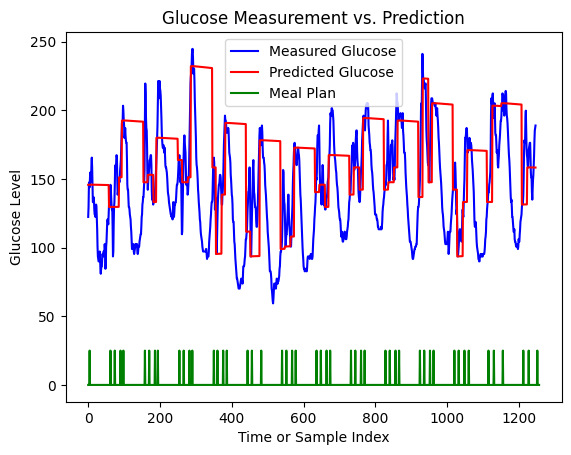

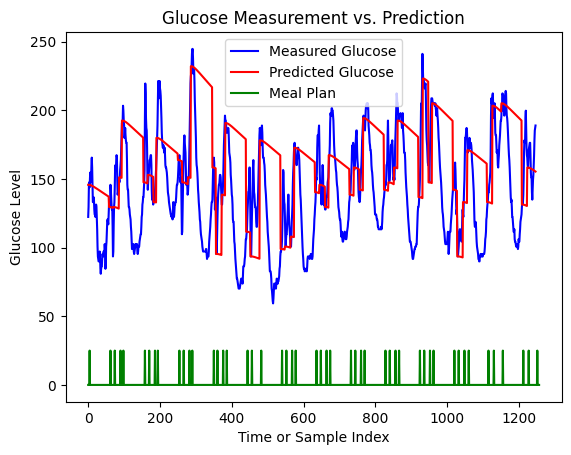

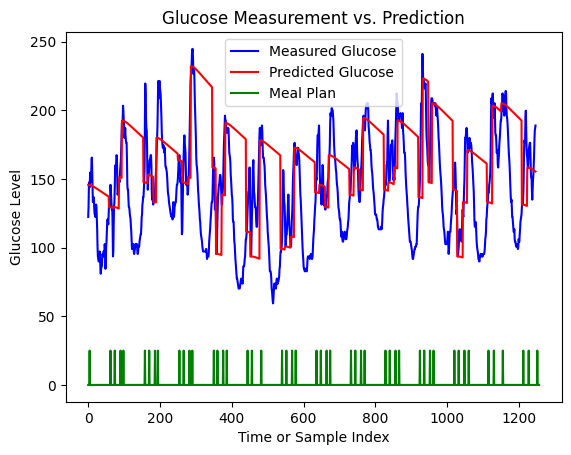

[2.00000000e+01 8.00000000e+00 0.00000000e+00 1.00000000e-01
 2.00000000e-01 2.00000000e+00 2.00000000e-03 5.00000000e-01
 1.08485446e-06 3.00000000e-05 1.00000000e+00]
[2.00000000e+01 8.00000000e+00 0.00000000e+00 1.00000000e-01
 2.63585756e-01 2.00000000e+00 3.00000000e-03 5.00000002e-01
 1.27446510e-01 1.00000000e-04 1.00000000e+00]


In [38]:
patient1=DiabetesDataset('/home/fyyy0407/RL/Deep_Q_Learning/T2DM/7.csv')
df=pd.read_csv('/home/fyyy0407/RL/Deep_Q_Learning/T2DM/7.csv')

indices = df.index[patient1.meal== 1].tolist()
meal_times=len(indices)
total_y=[]
total_v=[]
total_init=[]
total_len=[]
for i in range(0,meal_times-1):
    index=indices[i]
    next_index=indices[i+1]
    dv_y=[patient1.diabete_record[index:next_index+1].values,\
        #   patient1.insulin_doses[index:next_index+1].values]
          patient1.insulin_doses[index:next_index+1].values+10*patient1.nonin_medi[index:next_index+1].values]
    dv_y_init = [sublist[2] for sublist in dv_y]
    dv_v=patient1.insulin_doses[index:next_index+1]+10*patient1.nonin_medi[index:next_index+1]
    dv_len=next_index-index
    total_y.append(dv_y)
    total_v.append(dv_v)
    total_init.append(dv_y_init)
    total_len.append(dv_len)
index=indices[0]
last_index=indices[-1]
G=patient1.diabete_record.values[index:last_index]
# initial value
llh=Qls(G,sigma,theta_history[0],total_v,total_len,total_init,meal_times)
# after optimization
llh=Qls(G,sigma,theta_history[1],total_v,total_len,total_init,meal_times)
llh=Qls(G,sigma,theta_history[2],total_v,total_len,total_init,meal_times)
llh=Qls(G,sigma,theta_history[3],total_v,total_len,total_init,meal_times)
# llh=Qls(G,sigma,theta_history[30],total_v,total_init,meal_times)
print(theta_history[0])
print(theta_history[3])